# **Stock Market Sentiment Analysis using NLTK and BeautifulSoup**

## **Dependencies**

In [72]:
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from datetime import timedelta
from charminal import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

## **URL and Tickers**

In [73]:
finviz_url = 'https://finviz.com/quote.ashx?t='

# tickers = ['GOOG', 'NVDA', 'AAPL', 'MSFT', 'INTC', 'AMD', 'TSLA', 'META']
tickers = ['AMZN', 'NVDA', 'AAPL', 'AMD', 'INTC']

## **Fetch The Data from The URLs**
Parse the HTML and find the `id` as `news_id`

In [74]:
news_tables = {}
start_time = time.time()
for ticker in tickers:
  # Append the ticker name at the back of the finviz_url
  url = finviz_url + ticker

  # Create a request to the url
  request = Request(url=url, headers={'user-agent': 'my-app'})

  # Capture the response
  response = urlopen(request)
  
  # Parse the content of HTML using BeautifulSoup
  html = BeautifulSoup(response, 'html.parser')
  news_table = html.find(id='news-table')
  news_tables[ticker] = news_table
  print(f'{EMOJI_TIME} Fetched data for {ticker} ticker in {timedelta(seconds=time.time() - start_time)}')

print(f'{EMOJI_FINISH} Finished in {timedelta(seconds=time.time() - start_time)}')

⌛ Fetched data for AMZN ticker in 0:00:05.002574
⌛ Fetched data for NVDA ticker in 0:00:06.194517
⌛ Fetched data for AAPL ticker in 0:00:08.382781
⌛ Fetched data for AMD ticker in 0:00:10.989462
⌛ Fetched data for INTC ticker in 0:00:13.108609
🏁 Finished in 0:00:13.108804


## **Test Code**

In [75]:
# amzn_data = news_tables['AMZN']
# amzn_rows = amzn_data.findAll('tr')
# 
# for idx, row in enumerate(amzn_rows):
#   title = row.a.text
#   timestamp = row.td.text.strip()
#   print(timestamp + ' ' + title)

## **Find The Wanted Data: Date, Time, and News Title**

### **Note for `date_and_time`**

The data can contain both `date` and `time`, and just `time`. To handle this, we can use `.split()`, and then evaluate the length of the output.
* `if len(date_and_time) > 1`: contains `date` and `time`
* `else`: just contains `time`

In [76]:
# List to store the parsed data
parsed_data = []

# Iterate through the tables from news_tables
for ticker, news_table in news_tables.items():
  # Iterate through the rows of the tables, and find <tr> element
  for row in news_table.findAll('tr'):
    # Parse the title
    title = row.a.text
    # Remove the trailings
    title = title.strip()

    # Parse the date and time
    # Format: "Nov-10-24 09:05AM"
    date_and_time = row.td.text
    # Remove the trailings
    date_and_time = date_and_time.strip()
    # Split the time and date
    date_and_time = date_and_time.split(' ')

    # If the length of date_and_time is larger than 1
    if len(date_and_time) > 1:
      date = date_and_time[0]
      time = date_and_time[1]

    else:
      time = date_and_time[0]

    parsed_data.append([ticker, date, time, title])

## **Make the DataFrame**

In [77]:
df = pd.DataFrame(parsed_data, columns=['ticker', 'date', 'time', 'title'])

def convert_date(date_str):
  if date_str == 'Today':
    return pd.to_datetime('today')
  else:
    return date_str
  
def convert_time(time_str):
  return pd.to_datetime(time_str)
  
df['date'] = df['date'].apply(convert_date)
df['date'] = pd.to_datetime(df['date']).dt.date
df['time'] = df['time'].apply(convert_time).dt.time

/tmp/ipykernel_97346/2693382224.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date']).dt.date


## **Transform the Date Format of the Data**
* There are several data with a value of `Today` --> Need to transform into `today` and then `datetime`
* The `time` is in the format of `09:17PM` --> Need to transform into `datetime`

## **Calculate The Compound Sentiment Analysis Score**

In [78]:
vader = SentimentIntensityAnalyzer()

f = lambda title: vader.polarity_scores(title)['compound']
df['compound'] = df['title'].apply(f)

## **Create A New DataFrame**

In [79]:
work_df = df[['ticker', 'date', 'compound']]


In [80]:
df.head(10)

,ticker,date,time,title,compound
0,AMZN,2024-11-11,16:12:00,New Whole Foods to anchor shopping center in B...,0.0000
1,AMZN,2024-11-11,13:00:00,"How Big Tech, AI could fit into Trump's immigr...",0.3612
2,AMZN,2024-11-11,12:42:00,Amazon launches drone delivery in Phoenix,0.1779
3,AMZN,2024-11-11,11:30:00,How a Trump presidency would impact Big Tech,0.0000
4,AMZN,2024-11-11,08:04:00,Amazon.com Inc. (AMZN): Ken Fishers AI-Driven ...,0.3818
5,AMZN,2024-11-11,06:45:00,"1 ""Magnificent Seven"" Stock That's a Screaming...",0.4767
6,AMZN,2024-11-11,06:10:00,Exclusive: Amazon developing driver eyeglasses...,0.2960
7,AMZN,2024-11-11,06:00:00,Unlocking Intrinsic Value: Analysis of Amazon....,0.3400
8,AMZN,2024-11-11,05:00:00,These Are the 10 Most Popular Grocery Stores i...,0.4754
9,AMZN,2024-11-11,04:51:00,"Billionaires Bill Gates, Jeff Bezos, and Sam A...",0.6486


In [81]:
work_df.head(10)

,ticker,date,compound
0,AMZN,2024-11-11,0.0000
1,AMZN,2024-11-11,0.3612
2,AMZN,2024-11-11,0.1779
3,AMZN,2024-11-11,0.0000
4,AMZN,2024-11-11,0.3818
5,AMZN,2024-11-11,0.4767
6,AMZN,2024-11-11,0.2960
7,AMZN,2024-11-11,0.3400
8,AMZN,2024-11-11,0.4754
9,AMZN,2024-11-11,0.6486


## **Change The Orientation of The `work_df`**

In [82]:
mean_df = work_df.groupby(['ticker', 'date']).mean()
mean_df = mean_df.unstack()
mean_df = mean_df.xs('compound', axis=1).transpose()

### **Why do we need this `unstack()` and `xs()`?**

#### **`mean_df` after `groupby().mean()`**
| ticker | date       | compound |
| ------ | -----------| ---------|
| AAPL	 | 2024-11-10 |	0.1      |
| AAPL	 | 2024-11-11 |	0.2      |
| GOOG	 | 2024-11-10 |	-0.1     |
| GOOG	 | 2024-11-11 |	0.3      |

#### **It is more desirable for the .plot() function to have:**
- Dates as the index (x-axis).
- Tickers as separate columns (one for each line on the plot).
- Sentiment scores as the values in these columns.

#### **So we need to change the mean_df to be:**

| date	      | AAPL | GOOG |
| ----------- | ---- | ---- |
| 2024-11-10	| 0.1 |	-0.1  |
| 2024-11-11	| 0.2 |	0.3   |

<Figure size 1500x1000 with 0 Axes>

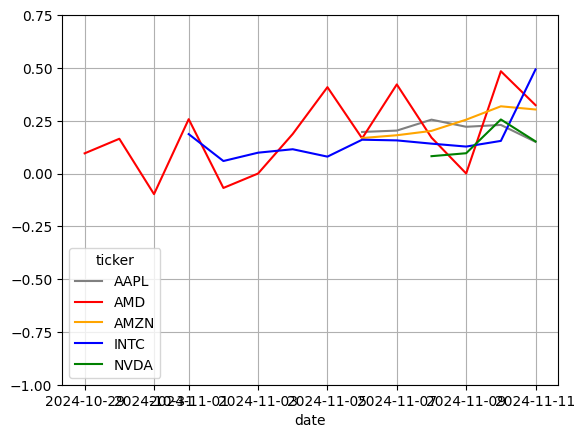

In [83]:
color_dict = {
  'AMZN': 'orange',
  'NVDA': 'green',
  'AAPL': 'gray',
  'AMD': 'red',
  'INTC': 'blue'
}

plt.figure(figsize=(15, 10))
mean_df.plot(kind='line', color=[color_dict[ticker] for ticker in mean_df.columns])
plt.yticks(np.arange(-1, 1, 0.25))
plt.grid()
plt.show()

In [84]:
print(mean_df.head(10))

ticker          AAPL       AMD      AMZN      INTC  NVDA
date                                                    
2024-10-29       NaN  0.095527       NaN       NaN   NaN
2024-10-30       NaN  0.164552       NaN       NaN   NaN
2024-10-31       NaN -0.097600       NaN       NaN   NaN
2024-11-01       NaN  0.257414       NaN  0.186582   NaN
2024-11-02       NaN -0.068300       NaN  0.059200   NaN
2024-11-03       NaN  0.000000       NaN  0.098667   NaN
2024-11-04       NaN  0.187410       NaN  0.114967   NaN
2024-11-05       NaN  0.408880       NaN  0.079962   NaN
2024-11-06  0.196753  0.166567  0.168059  0.160100   NaN
2024-11-07  0.203306  0.421900  0.181241  0.156871   NaN
